In [ ]:
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, GRU, Bidirectional, Dense, Dropout, Conv1D, MaxPooling1D
from keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

import json
import numpy as np
import pandas as pd
import random
from matplotlib import pyplot as plt
import seaborn as sns
from wordcloud import WordCloud,STOPWORDS
import missingno as msno

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

from tensorflow.keras.preprocessing import text
import keras
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout
from keras.callbacks import ReduceLROnPlateau

from tensorflow.keras.preprocessing.sequence import pad_sequences
import nltk
from nltk import word_tokenize
from nltk.stem import PorterStemmer

import torch
from torch.utils.data import Dataset

from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from transformers import pipeline
from transformers import DistilBertTokenizerFast
from transformers import BertForSequenceClassification, BertTokenizerFast
# from transformers import TFDistilBertForSequenceClassification, TFTrainer, TFTrainingArguments
from transformers import BertTokenizer#, TFBertForSequenceClassification, BertConfig
from transformers import TrainingArguments, Trainer

torch.cuda.is_available()

from sklearn.metrics import classification_report, confusion_matrix

from keras_tuner import RandomSearch
from tensorflow.keras.optimizers import Adam


In [96]:
import json
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from keras_tuner import RandomSearch
# import Actication
from tensorflow.keras.layers import Activation
from tensorflow.keras.losses import KLDivergence

# Load the intents JSON file
def load_json_file(filename):
    with open(filename) as f:
        file = json.load(f)
    return file

filename = 'intents_exp.json'
intents = load_json_file(filename)

# Create a DataFrame to hold the patterns and associated tags
def create_df():
    df = pd.DataFrame({'Pattern': [], 'Tag': []})
    return df

df = create_df()

# Extract intent information from the JSON file and populate the DataFrame
def extract_json_info(json_file, df):
    for intent in json_file['intents']:
        for pattern in intent['patterns']:
            sentence_tag = [pattern, intent['tag']]
            df.loc[len(df.index)] = sentence_tag
    return df

df = extract_json_info(intents, df)

# Preprocess the text data: Tokenization and Stemming
stemmer = PorterStemmer()
ignore_words = ['?', '!', ',', '.']

def preprocess_pattern(pattern):
    words = word_tokenize(pattern.lower())
    stemmed_words = [stemmer.stem(word) for word in words if word not in ignore_words]
    return " ".join(stemmed_words)

df['Pattern'] = df['Pattern'].apply(preprocess_pattern)

# Prepare labels for training
labels = df['Tag'].unique().tolist()
labels = [s.strip() for s in labels]

num_labels = len(labels)
id2label = {id: label for id, label in enumerate(labels)}
label2id = {label: id for id, label in enumerate(labels)}

df['labels'] = df['Tag'].map(lambda x: label2id[x.strip()])

# Prepare the data for training
X = list(df['Pattern'])
y = list(df['labels'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Tokenize the text data
tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

# Convert text to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences to make them of uniform length
max_len = 100  # Maximum sequence length
X_train_pad = pad_sequences(X_train_seq, padding='post', maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, padding='post', maxlen=max_len)

# Ensure the data is in NumPy array format
X_train_pad = np.array(X_train_pad)
X_test_pad = np.array(X_test_pad)
y_train = np.array(y_train)
y_test = np.array(y_test)

# Build the model using Keras Tuner
def build_model(hp):
    model = Sequential([
        Embedding(input_dim=5000, output_dim=hp.Choice('embedding_dim', [50, 128, 300]), input_length=max_len),
        Bidirectional(LSTM(hp.Int('lstm_units', min_value=32, max_value=128, step=32), return_sequences=False)),
        Dropout(hp.Choice('dropout_rate', [0.2, 0.5])),
        Dense(64, activation='relu'),
        Dense(num_labels, activation='softmax')
    ])
    model.compile(optimizer=Adam(hp.Choice('learning_rate', [0.001, 0.0005, 0.0001])),
                  loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def build_model2(hp):
    model = Sequential([
        # Embedding Layer
        Embedding(input_dim=5000, output_dim=hp.Choice('embedding_dim', [50, 128, 300]), input_length=max_len),
        
        # Bidirectional LSTM Layer (modified to not return sequences)
        Bidirectional(LSTM(hp.Int('lstm_units', min_value=32, max_value=128, step=32))),
        
        # Dropout Layer
        Dropout(hp.Choice('dropout_rate', [0.2, 0.5])),
        
        # Dense Layer with flexible activation function
        Dense(64),
        Activation(hp.Choice('dense_activation', ['relu', 'tanh', 'sigmoid'])),  # You can try ReLU, Tanh, and Sigmoid
        
        # Output Layer (one output per sequence)
        Dense(num_labels),
        Activation(hp.Choice('output_activation', ['softmax', 'sigmoid']))  # Test softmax or sigmoid for output
    ])
    
    # Compile the model with a tunable loss function
    loss_function = hp.Choice('loss_function', 
                               ['sparse_categorical_crossentropy', 
                                'categorical_crossentropy', 
                                'binary_crossentropy'])  
    
    # Handle KL Divergence loss
    if loss_function == 'kldivergence':
        loss = KLDivergence()
    else:
        loss = loss_function  # For categorical and sparse categorical
    
    model.compile(optimizer=Adam(hp.Choice('learning_rate', [0.001, 0.0005, 0.0001])),
                  loss=loss,
                  metrics=['accuracy'])
    
    return model

# Set up Keras Tuner for hyperparameter optimization
tuner = RandomSearch(build_model2,
                     objective='val_accuracy',
                     max_trials=10,
                     directory='my_dir2',
                     project_name='intent_classifier',
                     overwrite=True)

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Hyperparameter tuning
tuner.search(X_train_pad, y_train, epochs=20, validation_split=0.1, callbacks=[early_stopping])

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Evaluate the best model on test data
best_model.evaluate(X_test_pad, y_test)


Trial 10 Complete [00h 00m 01s]

Best val_accuracy So Far: 0.5714285969734192
Total elapsed time: 00h 01m 54s
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5986 - loss: 1.4483


[1.4611455202102661, 0.5899280309677124]

In [ ]:
best_trial = tuner.oracle.get_best_trials(num_trials=1)[0]
print("Best Hyperparameters: ", best_trial.hyperparameters.values)
print("Best Trial Performance: ", best_trial.summary())

Best Hyperparameters:  {'embedding_dim': 128, 'lstm_units': 32, 'dropout_rate': 0.5, 'dense_activation': 'tanh', 'output_activation': 'softmax', 'loss_function': 'sparse_categorical_crossentropy', 'learning_rate': 0.001}
Trial 07 summary
Hyperparameters:
embedding_dim: 128
lstm_units: 32
dropout_rate: 0.5
dense_activation: tanh
output_activation: softmax
loss_function: sparse_categorical_crossentropy
learning_rate: 0.001
Score: 0.5714285969734192
Best Trial Performance:  None


In [112]:
# tuner.results_summary()

In [22]:
# Preprocessing Functions
def preprocess_data(data, config):
    if config["synonym_handler"]:
        data = expand_synonyms(data)
    
    if config["tokenization"] == "keras_tokenizer":
        tokenizer = Tokenizer(num_words=5000)
        tokenizer.fit_on_texts(data)
        sequences = tokenizer.texts_to_sequences(data)
    elif config["tokenization"] == "character_tokenizer":
        sequences = [[ord(char) for char in text] for text in data]
    elif config["tokenization"] == "bag_of_words":
        vectorizer = CountVectorizer(max_features=5000)
        return vectorizer.fit_transform(data).toarray(), None
    elif config["vectorization"] == "tfidf":
        vectorizer = TfidfVectorizer(max_features=5000)
        return vectorizer.fit_transform(data).toarray(), None
    
    if config["padding"] in ["post", "pre"]:
        max_len = max(len(seq) for seq in sequences)
        sequences = pad_sequences(sequences, maxlen=max_len, padding=config["padding"])
    
    return sequences, tokenizer


def expand_synonyms(data):
    new_data = []
    for sentence in data:
        words = word_tokenize(sentence)
        new_sentence = []
        for word in words:
            synonyms = wordnet.synsets(word)
            synonym = word if not synonyms else synonyms[0].lemmas()[0].name()
            new_sentence.append(synonym)
        new_data.append(" ".join(new_sentence))
    return new_data


# Build and Train Model
def build_and_train_model(X_train, y_train, X_test, y_test, config, num_classes):
    model = Sequential()
    if config["vectorization"] == "embedding":
        model.add(Embedding(input_dim=5000, output_dim=128, input_length=X_train.shape[1]))
    
    for layer_units in config["layers"]:
        if config["architecture"] == "LSTM":
            model.add(LSTM(layer_units, return_sequences=(layer_units != config["layers"][-1])))
        elif config["architecture"] == "GRU":
            model.add(GRU(layer_units, return_sequences=(layer_units != config["layers"][-1])))
        elif config["architecture"] == "Bidirectional_LSTM":
            model.add(Bidirectional(LSTM(layer_units, return_sequences=(layer_units != config["layers"][-1]))))
        model.add(Dropout(config["dropout"]))
    
    model.add(Dense(num_classes, activation="softmax"))
    model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    
    history = model.fit(
        X_train,
        y_train,
        validation_data=(X_test, y_test),
        epochs=config["epochs"],
        batch_size=config["batch_size"],
        callbacks=[EarlyStopping(monitor="val_loss", patience=3)],
        verbose=1
    )
    return model, history

configs = [
    # Word Tokenization + Simple LSTM
    {
        "tokenization": "keras_tokenizer",
        "vectorization": "embedding",
        "architecture": "LSTM",
        "layers": [128, 64],
        "dropout": 0.2,
        "batch_size": 32,
        "epochs": 20,
        "padding": "post",
        "synonym_handler": False,
        "optimizer": "adam",
    },
    # Character Tokenization + GRU
    {
        "tokenization": "character_tokenizer",
        "vectorization": "embedding",
        "architecture": "GRU",
        "layers": [128, 64],
        "dropout": 0.3,
        "batch_size": 16,
        "epochs": 20,
        "padding": "pre",
        "synonym_handler": False,
        "optimizer": "sgd",
    },
    # Bag of Words + Dense Layers
    {
        "tokenization": "bag_of_words",
        "vectorization": "bow",
        "architecture": "Dense",
        "layers": [256, 128, 64],
        "dropout": 0.2,
        "batch_size": 64,
        "epochs": 20,
        "padding": "none",
        "synonym_handler": True,
        "optimizer": "adam",
    },
    # TF-IDF + GRU
    # {
    #     "tokenization": "tfidf",
    #     "vectorization": "tfidf",
    #     "architecture": "GRU",
    #     "layers": [128, 64],
    #     "dropout": 0.3,
    #     "batch_size": 32,
    #     "epochs": 20,
    #     "padding": "none",
    #     "synonym_handler": False,
    #     "optimizer": "adam",
    # },
    # Bidirectional LSTM + Word Tokenization
    {
        "tokenization": "keras_tokenizer",
        "vectorization": "embedding",
        "architecture": "Bidirectional_LSTM",
        "layers": [128, 64],
        "dropout": 0.2,
        "batch_size": 16,
        "epochs": 20,
        "padding": "post",
        "synonym_handler": True,
        "optimizer": "rmsprop",
    },
    # CNN + LSTM
    {
        "tokenization": "keras_tokenizer",
        "vectorization": "embedding",
        "architecture": "CNN_LSTM",
        "layers": [256, 128],
        "dropout": 0.5,
        "batch_size": 64,
        "epochs": 20,
        "padding": "post",
        "synonym_handler": False,
        "optimizer": "adam",
    },
]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
num_classes = len(set(y))

results = []

history_results = []
config_results = []
accuracies = []

# Итерация по всем конфигурациям
for config in configs:
    print(f"\nRunning configuration: {config}\n")

    # 1. Токенизация
    if config["tokenization"] == "keras_tokenizer":
        tokenizer = Tokenizer(num_words=5000)
        tokenizer.fit_on_texts(X_train)
        X_train_seq = tokenizer.texts_to_sequences(X_train)
        X_test_seq = tokenizer.texts_to_sequences(X_test)
        max_len = max(len(seq) for seq in X_train_seq)
        if config["padding"] != "none":
            X_train_padded = pad_sequences(X_train_seq, maxlen=max_len, padding=config["padding"])
            X_test_padded = pad_sequences(X_test_seq, maxlen=max_len, padding=config["padding"])
        else:
            X_train_padded = X_train_seq
            X_test_padded = X_test_seq

    elif config["tokenization"] == "character_tokenizer":
        tokenizer = Tokenizer(char_level=True)
        tokenizer.fit_on_texts(X_train)
        X_train_seq = tokenizer.texts_to_sequences(X_train)
        X_test_seq = tokenizer.texts_to_sequences(X_test)
        max_len = max(len(seq) for seq in X_train_seq)
        if config["padding"] != "none":
            X_train_padded = pad_sequences(X_train_seq, maxlen=max_len, padding=config["padding"])
            X_test_padded = pad_sequences(X_test_seq, maxlen=max_len, padding=config["padding"])
        else:
            X_train_padded = X_train_seq
            X_test_padded = X_test_seq

    elif config["tokenization"] == "bag_of_words":
        vectorizer = CountVectorizer(max_features=5000)
        X_train_padded = vectorizer.fit_transform(X_train).toarray()
        X_test_padded = vectorizer.transform(X_test).toarray()

    elif config["tokenization"] == "tfidf":
        vectorizer = TfidfVectorizer(max_features=5000)
        X_train_padded = vectorizer.fit_transform(X_train).toarray()
        X_test_padded = vectorizer.transform(X_test).toarray()

    else:
        raise ValueError(f"Unknown tokenization method: {config['tokenization']}")

    # 2. Построение модели
    model = Sequential()
    if config["vectorization"] == "embedding":
        model.add(Embedding(input_dim=5000, output_dim=128, input_length=max_len))

    if config["architecture"] == "LSTM":
        for layer_units in config["layers"]:
            model.add(LSTM(layer_units, return_sequences=(layer_units != config["layers"][-1])))
            model.add(Dropout(config["dropout"]))
    elif config["architecture"] == "GRU":
        for layer_units in config["layers"]:
            model.add(GRU(layer_units, return_sequences=(layer_units != config["layers"][-1])))
            model.add(Dropout(config["dropout"]))
    elif config["architecture"] == "Bidirectional_LSTM":
        for layer_units in config["layers"]:
            model.add(Bidirectional(LSTM(layer_units, return_sequences=(layer_units != config["layers"][-1]))))
            model.add(Dropout(config["dropout"]))
    elif config["architecture"] == "Dense":
        model.add(Dense(config["layers"][0], activation='relu'))
        model.add(Dropout(config["dropout"]))
        for layer_units in config["layers"][1:]:
            model.add(Dense(layer_units, activation='relu'))
            model.add(Dropout(config["dropout"]))
        model.add(Dense(len(set(y_train)), activation='softmax'))
    elif config["architecture"] == "CNN_LSTM":
        model.add(Conv1D(128, kernel_size=3, activation='relu'))
        model.add(MaxPooling1D(pool_size=2))
        for layer_units in config["layers"]:
            model.add(LSTM(layer_units, return_sequences=(layer_units != config["layers"][-1])))
            model.add(Dropout(config["dropout"]))

    # Финальный слой
    if config["architecture"] != "Dense":
        model.add(Dense(len(set(y_train)), activation='softmax'))

    # Компиляция
    model.compile(
        optimizer=config["optimizer"],
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    # 3. Тренировка модели
    history = model.fit(
        np.array(X_train_padded), np.array(y_train),
        validation_data=(np.array(X_test_padded), np.array(y_test)),
        epochs=config["epochs"],
        batch_size=config["batch_size"],
        callbacks=[EarlyStopping(monitor='val_loss', patience=3)],
        verbose=1
    )

    history_results.append(history.history)
    config_results.append(config)

    # Evaluate the model
    y_pred = model.predict(np.array(X_test_padded)).argmax(axis=1)
    acc = classification_report(y_test, y_pred, output_dict=True)['accuracy']
    accuracies.append(acc)

    print(f"Accuracy for config {config}: {acc}")

# Печать результатов
print("\nFinal results:")
for config, acc in results:
    print(f"Config: {config}, Accuracy: {acc}")


# print("\nFinal Results:\n", results)



Running configuration: {'tokenization': 'keras_tokenizer', 'vectorization': 'embedding', 'architecture': 'LSTM', 'layers': [128, 64], 'dropout': 0.2, 'batch_size': 32, 'epochs': 20, 'padding': 'post', 'synonym_handler': False, 'optimizer': 'adam'}

Epoch 1/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.0334 - loss: 3.6297 - val_accuracy: 0.0360 - val_loss: 3.5800
Epoch 2/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0695 - loss: 3.5561 - val_accuracy: 0.0504 - val_loss: 3.4969
Epoch 3/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.1026 - loss: 3.4366 - val_accuracy: 0.1223 - val_loss: 3.3290
Epoch 4/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.1627 - loss: 3.1644 - val_accuracy: 0.1511 - val_loss: 3.0630
Epoch 5/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.2148 - loss: 2.7873 - val_accuracy: 0.2230 - val_loss: 2.7249
Epoch 6/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.2875 - loss: 2.3113 - val_accuracy: 0.2878 - val_l

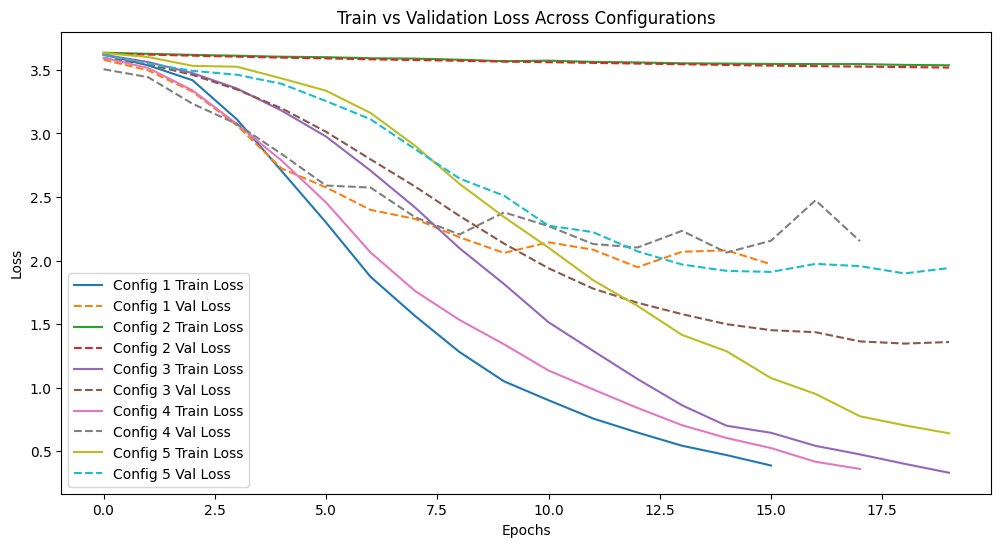

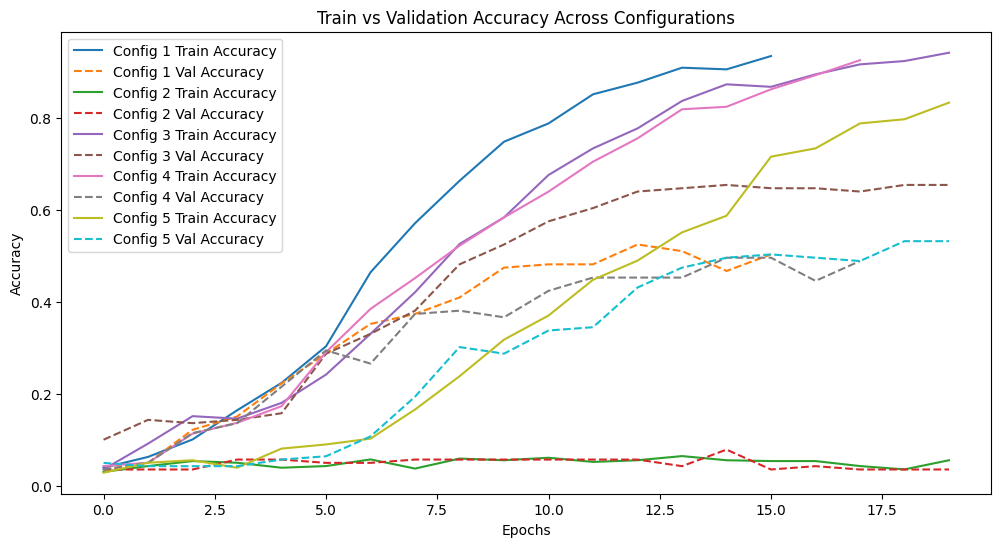

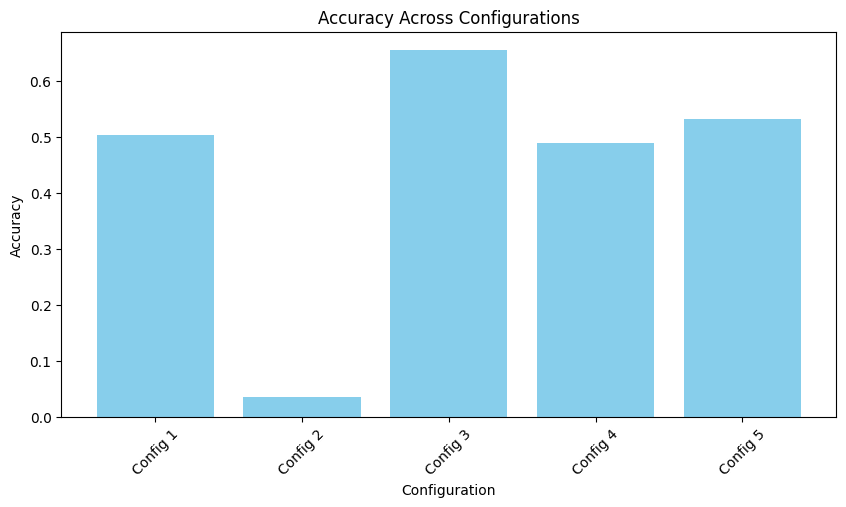

In [24]:
# 1. Train vs Validation Loss
plt.figure(figsize=(12, 6))
for i, history in enumerate(history_results):
    plt.plot(history['loss'], label=f'Config {i+1} Train Loss')
    plt.plot(history['val_loss'], label=f'Config {i+1} Val Loss', linestyle='--')
plt.title('Train vs Validation Loss Across Configurations')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 2. Train vs Validation Accuracy
plt.figure(figsize=(12, 6))
for i, history in enumerate(history_results):
    plt.plot(history['accuracy'], label=f'Config {i+1} Train Accuracy')
    plt.plot(history['val_accuracy'], label=f'Config {i+1} Val Accuracy', linestyle='--')
plt.title('Train vs Validation Accuracy Across Configurations')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# 3. Accuracy Across Configurations
plt.figure(figsize=(10, 5))
plt.bar(range(len(config_results)), accuracies, color='skyblue')
plt.xticks(range(len(config_results)), [f'Config {i+1}' for i in range(len(config_results))], rotation=45)
plt.title('Accuracy Across Configurations')
plt.xlabel('Configuration')
plt.ylabel('Accuracy')
plt.show()